In [27]:
# save the final model to file
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	model.fit(trainX, trainY, epochs=20, batch_size=64)#, verbose=0)
	# save model
	model.save('model.keras')


In [28]:

# entry point, run the test harness
run_test_harness()

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.8907 - loss: 0.3360
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9846 - loss: 0.0494
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9895 - loss: 0.0332
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9921 - loss: 0.0253
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9943 - loss: 0.0171
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9959 - loss: 0.0129
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9965 - loss: 0.0115
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9972 - loss: 0.0086
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9973 - loss: 0.0089
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9984 - loss: 0.0054
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9985 - loss: 0.0046
Epoch 12/20
938/938 ━━━━━━━━━━

In [29]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import load_model # type: ignore
from numpy import argmax
from tensorflow.keras.utils import load_img, img_to_array # type: ignore
import os

In [30]:
thumuc = os.getcwd() + "/../data"
files = sorted(os.listdir(thumuc))

In [48]:
def print_matrix(matrix):
    for row in matrix:
        print(" ".join(map(str, row)))

def load_image(path):
    # Load the image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"{path}"

    # Otsu's thresholding after Gaussian filtering - https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    #img = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    #_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    #img = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    #img = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

    # Resize the image to 28x28
    img = cv2.resize(img, (28, 28))

    # check if image is nagative 
    average_brightness = img.mean()
    if average_brightness > 100:
        img = 255 - img

    # Reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)

    # Print the 28x28 image array
    print_matrix(img.reshape(28, 28))

    # Prepare pixel data
    img = img.astype('float32') / 255.0


    # Display the image (without the batch dimension)
    plt.imshow(img.reshape(28, 28))#, cmap=plt.get_cmap('grey'))
    plt.axis('off')  # Hide axes for better display
    plt.show()

    return img

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 191 255 255 255 235 191 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 137 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 34 64 64 0 0 125 255 255 230 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 173 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 173 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 173 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 39 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 125 255 246 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 184 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 112 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 171 255 255 255 255 255 253 116 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 255 255 191 191 235 255 255 255 0 0 0 

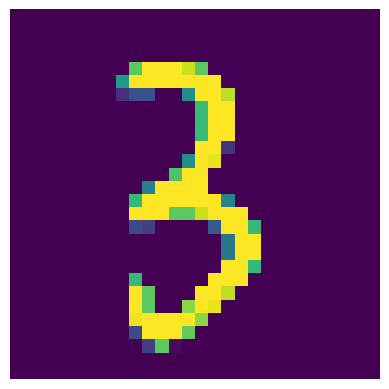

4c966962273240d7dd1a52de5e3d4d5e  -.png,3
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
255 255 255 255 255 255 14 14 14 14 14 14 14 14 0 14 14 14 14 14 0 8 14 0 14 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 167 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 238 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 33 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 183 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 88 0 255 255 19 0 0 0 0 146 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 146 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 37 0 0 0 0 146 0 0 0 0 0 0
0 0 0 0 

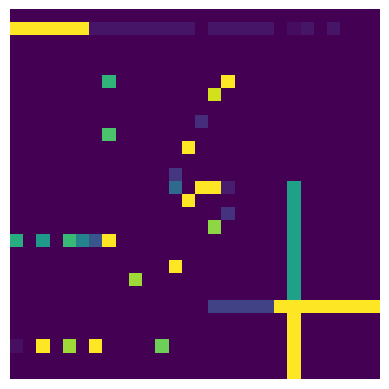

4ca1bafb9d8176b01230be5dbfae3e07  -.jpg,3
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 200 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 110 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 14 223 0 0 0 0 0 255 0 128 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0

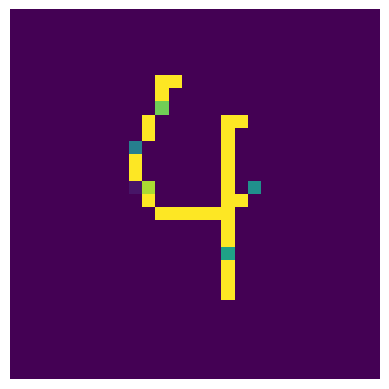

4ca5feeb85918fcc99e9fb1e1a14f46a  -.png,4
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 10 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 114 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 255 255 255 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 17 255 255 255 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0
0 0 0 0 0 0 0 0 255 255 255 0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0
0 0 0 0 0 0 0 0 255 255 255 0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0
0 0 0 0 0 0 0 255 255 255 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 255 255 255 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 255 255 0 

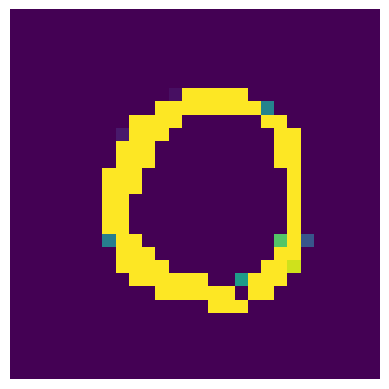

4cdc955c9d23efa56225d800c98510bf  -.jpg,0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 128 255 255 255 48 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 255 255 252 255 255 4 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 106 255 250 114 37 250 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 191 255 224 0 0 0 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 72 96 0 0 0 0 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 246 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 19 248 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 215 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 53 255 255 70 0 0 

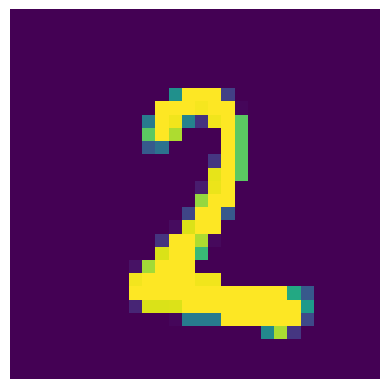

4ce764c71aba668c8ddcd895379eaa7c  -.png,2
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 136 255 87 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 223 255 87 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 223 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 223 255 34 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 223 255 87 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 87 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 87 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 87 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 255 0 9 9 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 189 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 196 0 0 0 0 0 0 0 0 0 0 0
0

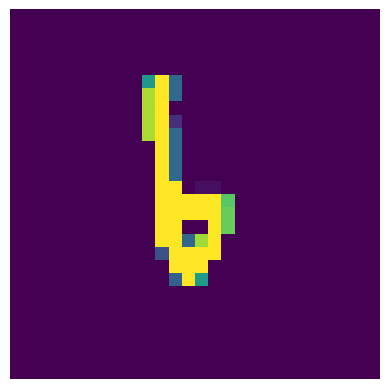

4d2542d9ad84a579894c7b53a1942ab6  -.png,6
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 255 255 255 255 255 255 0 0 0 0 0 0 0
0 0 0 0 0 255 255 0 0 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 255 255 255 255 255 255 0 0 0 0 0 255 255 0 0 

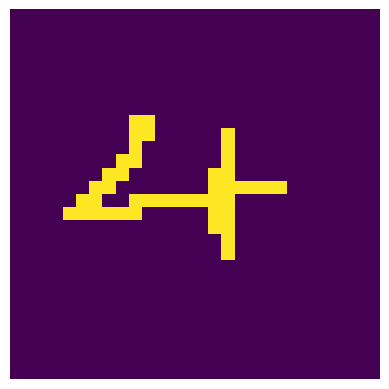

4d4102bc9d7658955ae6bded808fe603  -.jpg,4
0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 137 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 253 0 0 0 0 0 0 0 0 0
0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 170 0 238 0 65 0 0 0 0 0
0 255 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 255 0 0 0 0 0 0 9 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0
0 255 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
255 0 255 23 255 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 61 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 255 0 0 0 0 0 0 0 0 0 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 255 0 0 0 0 0 0 0 0 118 0 0 0 0
0 255 0 0 0 0 0 0 0 0 0 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 41 207 0 0 0 0 0 0 119 0 0 0 0
0 255 246 0 0 0 0 0 0 0 0 246 0 0 0 0 0 0 0 

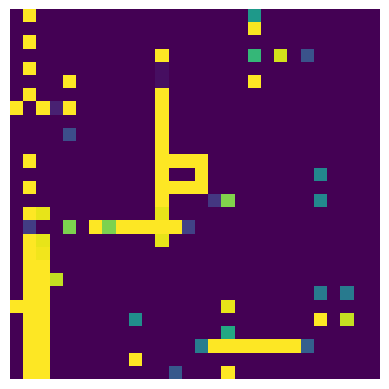

4d6bac6e90cf9ebddc3c4f75eb90dc3d  -.jpg,4
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 78 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 8 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 138 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 198 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

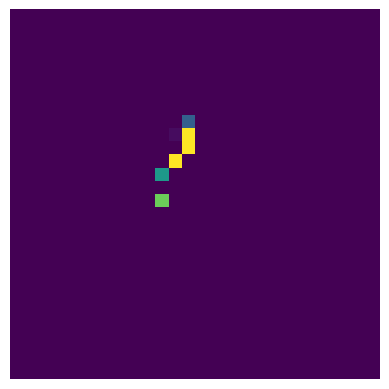

4d81ee9cd00a446bde6933f9d7230074  -.jpg,7
/home/tony/ml/temp/../data/4d8a0d9e667cc03d9a1f4d5ea33497a8  -.md
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 223 255 196 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 178 255 255 255 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 178 255 255 255 151 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 223 255 255 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 178 255 255 196 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 178 255 255 196 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 36 198 255 241 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 132 255 255 242 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 87 255 255 255 0 0 0 0 0 0 0 0 77 223 255 255 255 219 71 0 0
0 0 0 0 0 0 12 138 255 255 187 0 0 0 0 0 0 0 78 255 255 255 178 178 178 79 0 0
0 0 0 0 0 0 41 255 255 255 32 0 0 0 0 0 0 32 255 255 255 41 0 0 0 0 0 0
0 0 0 0 0 0 255 255 255 77 0 0 0 0 0 0 0 

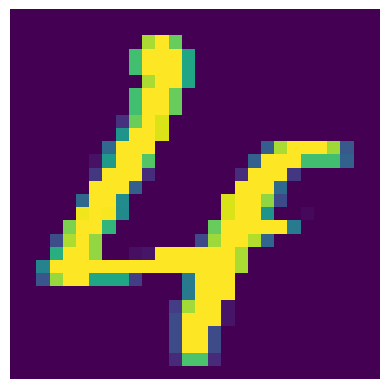

4d8dfaf7f0a022e634fb5b8a02387eda  -.jpg,4
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 48 0 0 0 0 96 0 0 107 255 255 221 255 96 0 0 0 0
0 0 0 0 0 0 0 0 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0
0 0 0 0 0 0 0 0 89 255 255 255 255 255 255 255 255 255 250 250 250 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 77 255 255 255 255 41 41 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 200 255 255 87 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 26 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 255 255 164 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 55 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 47 255 255 255 59 0 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2

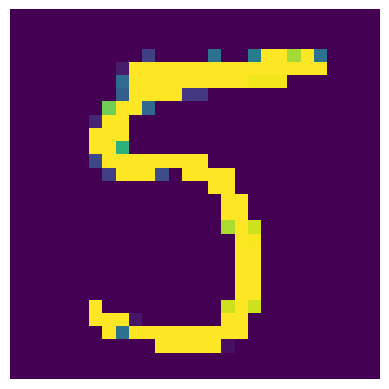

4d905e9f5a70ca1c92f47e1d24e1d5cd  -.png,5
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 198 255 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 246 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0
255 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 

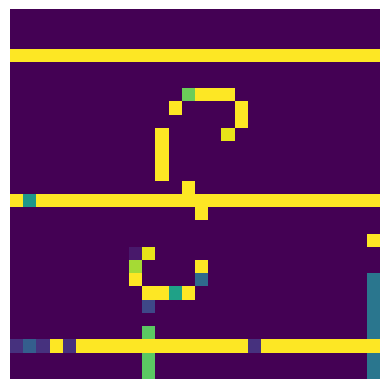

4dc0b06ec710dec41c35c5eb0f60e9c3  -.jpg,2
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 16 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 230 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 100 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 71 255 255 255 255 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 0 255 255 255 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 207 255 255 255 255 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 

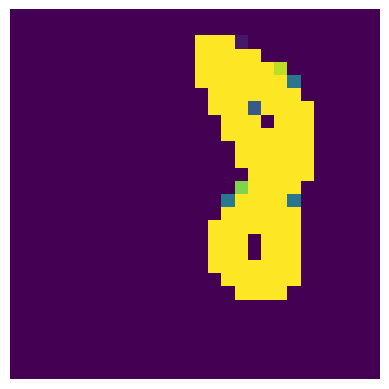

4dc496d674101e9ed26156d051d1421e  -.png,2
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 232 0 0 255 255 255 41 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 233 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 68 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 69 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 69 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 

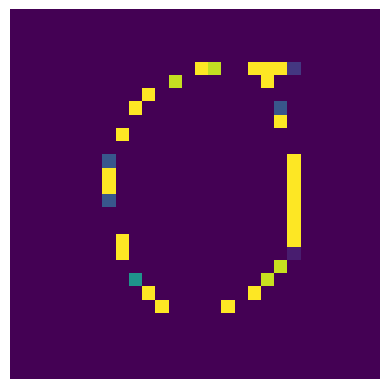

4e0ddacb6dbe3ce054bd06d4b2f23201  -.jpg,0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 250 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 255 96 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 2

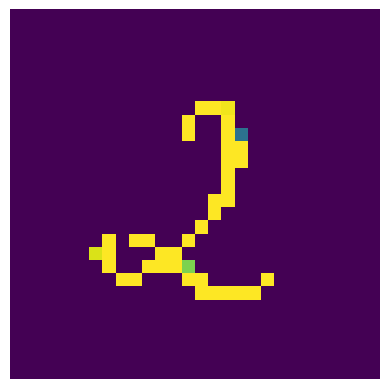

4e16a7747dd3d03c5f2d0edcdc566884  -.png,2
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 120 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 255 176 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 255 155 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 255 55 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 18 252 0 0 0 255 14 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 246 209 0 0 0 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 254 15 0 0 0 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 68 255 0 0 0 0 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 191 255 0 0 0 0 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 255 9 0 0 0 0 255 191 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 88 255 3 0 0 0 0 255 68 0 0 0 0 0 0 0 0 0 0

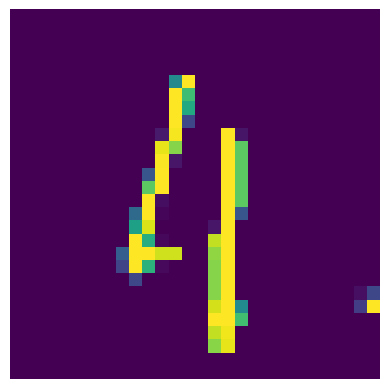

4e35eecbc2436a4a1183e6470c7f7f44  -.png,4


In [49]:
model = load_model('model.keras')
i = 600
def run():
  for file in files[i:i+17:1]:
    try:
      # load the image
      img = load_image(f"{thumuc}/{file}")
      # predict the class
      predict_value = model.predict(img, verbose=0)
     
      digit = argmax(predict_value)
      print(f"{file},{digit}")
      #print(file)

      #debug predict_vale array
      #print(predict_value)

    except Exception as e:
      #print(f"{file},8")
      print(e)
run()

In [ ]:
print("Hello world!")